In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os 
import osmnx as ox
import networkx as nx
import sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent.parent))
from src.plotting.styles import get_style, latex_escape

### Distance and Correlation

This Jupyter Notebook analyzes the spatial distances and correlations of bicycle counters in German cities. It allows you to check correlations between different counting sites and visualize the results.

The notebook is flexible: the city can be changed in Block 10 to run the analysis for any city with eco-counters.

1. Euclidean Distance: Compute straight-line distances between all counters in a city.
2. Bike Distance: Calculate realistic cycling distances along streets and bike paths.
3. Correlation: Check if counting sites show similar cycling activity patterns.
4. Visualization: Display distances and correlations for easy interpretation.

##### Supported Cities and Number of Eco-Counters

- "Stadt Heidelberg": 15 counter
- "Landeshauptstadt Stuttgart": 15 counter
- "Stadt Ludwigsburg": 15 counter
- "Stadt Mannheim": 14 counter
- "Stadt Freiburg": 10 counter
- "Stadt Reutlingen": 7 counter
- "Stadt Konstanz": 6 counter
- "Stadt Tübingen": 5 counter
- "Stadt Heilbronn": 4 counter
- "Stadt Lörrach": 2 counter

In [257]:
# allow imports from src/
PROJECT_ROOT = Path.cwd().parents[1]
sys.path.insert(0, str(PROJECT_ROOT))

# import dataloader function
from src.data.dataload import load_csv_folder_to_dataframe

DATA_DIR = PROJECT_ROOT / "data/raw"
PLOTS_DIR = PROJECT_ROOT / "outputs/plots"
distcorr_plot_dir = PLOTS_DIR / "distcorr"
distcorr_plot_dir.mkdir(parents=True, exist_ok=True)
TABLES_DIR = PROJECT_ROOT / "outputs/tables"
TABLES_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR = PROJECT_ROOT / "data/processed"

# if df_all.csv exists load it as dataframe (faster), else load from raw data
df_all_path = PROCESSED_DIR / "df_all.csv"
if df_all_path.exists():
    print("Loading preprocessed dataframe from", df_all_path)
    df_all = pd.read_csv(df_all_path)
else:
    ## get data and preprocess
    df_all = load_csv_folder_to_dataframe(DATA_DIR)

##  timestamps to datetime
df_all['iso_timestamp'] = pd.to_datetime(df_all['iso_timestamp'], utc=True, format='mixed')

# change columns to numerics
numeric_cols = [
    "channels_in", "channels_out", "channels_unknown", "channels_all", 
    "site_temperature", "site_rain_accumulation", "site_snow_accumulation"]

df_all[numeric_cols] = df_all[numeric_cols].apply(pd.to_numeric, errors='coerce')

df_all["count"] = df_all[["channels_out", "channels_in", "channels_unknown"]].fillna(0).sum(axis=1)

# subset of dataframe just for one town 
df_domain = df_all[df_all["domain_name"] == "Stadt Ludwigsburg"] ### change domain name here for other towns

title_domain = df_domain["domain_name"].iloc[0]
print(title_domain)
df_domain_grouped = df_domain.groupby("counter_site")

# get coordinates for every counter site
domain_coords = {
    name: (
        df_domain_grouped.get_group(name)["latitude"].iloc[0],
        df_domain_grouped.get_group(name)["longitude"].iloc[0]
    )
    for name in df_domain_grouped.groups.keys()
}

Loading preprocessed dataframe from c:\Users\Crabsi\Desktop\QDS MASTER\WS2526 01\Data Literacy\Project\fahrradzaehler\data\processed\df_all.csv
Stadt Ludwigsburg


#### 1. Bike Distance

In this step, we compute the realistic cycling distance between counter sites using the **Osmnx** package, which builds a graph of streets and bike paths.  

1.1. Create graph:
   - We define a **center node** as the mean latitude and longitude of all counter sites.  
   - The **network type** is set to `"bike"` to include only bike-accessible streets and paths.  
   - The **radius** is chosen as the half of the maximum Euclidean distance (+100m) between all counter sites to ensure all sites are included in the graph.  

1.2. Calculate distances: 
   - We use `nx.shortest_path_length()` from NetworkX to compute the shortest path (bike distance) between all pairs of counters on the graph.  
   - The results are stored in a **distance matrix**, similar in format to the Euclidean distance matrix.  

**Output:**  
A symmetric **bike distance matrix** where each element $(i,j)$ represents the shortest cycling distance between counter $i$ and counter $j$.

In [258]:
# 1.1 create graph from OSM streetmaps
# compute mean of lats and lons for center point
sites1 = list(domain_coords.keys())
lats = [coord[0] for coord in domain_coords.values()]
cp_lat = np.mean(lats)
lons = [coord[1] for coord in domain_coords.values()]
cp_lon = np.mean(lons)
# set mean as center point 
center_point = (cp_lat, cp_lon)  

# access streetmaps graph with bike lanes, with median cp and 3km radius (adjust if needed)
G = ox.graph_from_point(center_point, dist=5000, network_type='bike')
# nodes in our graph are our counter sites 
snapped_nodes = {}
counter_to_node_dist = {}
for name, (lat, lon) in domain_coords.items():
    node, dist = ox.distance.nearest_nodes(G, X=lon, Y=lat, return_dist=True)
    snapped_nodes[name] = node
    
# 1.2 compute shortest path distances between all counter sites
distances1 = {}
for i in snapped_nodes:
    for j in snapped_nodes:
        if (j, i) in distances1:
            distances1[(i, j)] = distances1[(j, i)]
            continue
        if i == j:
            distances1[(i, j)] = 0
            continue
        d = nx.shortest_path_length(G, snapped_nodes[i], snapped_nodes[j], weight='length')
        distances1[(i, j)] = d
        #print(f"distance between {i} and {j}: {d:.1f} m")


# 1.3 create distance matrix (for bike dist)
dist_matrix = pd.DataFrame(index=sites1, columns=sites1)
for (site1, site2), dist in distances1.items():
    dist_matrix.loc[site1, site2] = dist
    dist_matrix.loc[site2, site1] = dist

# fill diagonal with 0
dist_matrix.fillna(0, inplace=True)


#### 2. Euclidean Distance

In this step, we compute the Euclidean (straight-line) distance between all counter sites based on their geographic coordinates.

We first convert the latitude and longitude from degrees to a Cartesian coordinate system using the following formula:

\begin{aligned}
x &= R \cdot \cos(\varphi_0) \cdot \mathrm{rad}(\lambda), \\
y &= R \cdot \mathrm{rad}(\varphi),
\end{aligned}
where
$\mathrm{rad}(\alpha) = \alpha \cdot \frac{\pi}{180}$

Variables:
- $\varphi$ : latitude in degrees 
- $\lambda$ : longitude in degrees 
- $\varphi_0$ : reference latitude
- $R = 6{,}371{,}000\,\text{m}$ : earth radius

Once converted to Cartesian coordinates, the Euclidean distance $d_{ij}$ between two counters $i$ and $j$ is computed as:

$d_{ij} = \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2}$

**Output:**  
A symmetric **distance matrix** where each element $(i,j)$ represents the straight-line distance between counter $i$ and counter $j$

In [259]:
# 2.1 reference latitude for the conversion
snapped_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in snapped_nodes.values()]
lat0 = np.mean([lat for lat, lon in snapped_coords])

# 2.2 define function to convert lat/lon to x/y in meters
def latlon_to_xy(coord, lat0=lat0):
    lat, lon = coord
    R = 6371000 # radius of earth in meters
    x = R * np.radians(lon) * np.cos(np.radians(lat0))
    y = R * np.radians(lat)
    return np.array([x, y])

# 2.3 distance matrix
dist_matrix_euclid = pd.DataFrame(index=sites1, columns=sites1, dtype=float)

for a in sites1:
    for b in sites1:
        n1 = (G.nodes[snapped_nodes[a]]['y'], G.nodes[snapped_nodes[a]]['x'])
        n2 = (G.nodes[snapped_nodes[b]]['y'], G.nodes[snapped_nodes[b]]['x'])
        p1 = latlon_to_xy(n1)
        p2 = latlon_to_xy(n2)
        dist_matrix_euclid.loc[a, b] = np.linalg.norm(p1 - p2)

diff_matrix = dist_matrix - dist_matrix_euclid
neg_pairs = np.where(diff_matrix < 0)
print(neg_pairs)

(array([], dtype=int64), array([], dtype=int64))


#### Optional

The next cell block is mainly to plot the routes between two respective counter sites (uncomment the last line of the loop). For Tübingen this is not too much as

$\binom{n}{2} = \frac{n(n-1)}{2}$

so for 5 stations 

$\binom{5}{2} = \frac{5(5-1)}{2}=10$

but for cities like Ludwigsburg or Stuttgart we have 15 counters, so proceed with caution.

In [260]:
# compute all the routes as well and store them in a dict
# you can plot it too! (uncomment last line)
routes = {}

keys = list(snapped_nodes.keys())

for i in keys:
    for j in keys:
        if (j, i) in routes:
            routes[(i, j)] = routes[(j, i)]
            continue
        if i == j:
            routes[(i, j)] = [snapped_nodes[i]]
            continue
        r = nx.shortest_path(G, snapped_nodes[i], snapped_nodes[j], weight='length')
        routes[(i, j)] = r
        # ox.plot_graph_route(G, r)


#### 3. Correlation

This section analyzes correlations between bicycle counts at different counter sites.

##### 3.1 Correlation Matrix (All Available Data)

We compute the Pearson correlation matrix using all available overlapping data points.
Missing values are ignored pairwise.

The resulting correlation matrix is visualized as a heatmap to highlight similarities
and differences between counter sites.

##### 3.2 Correlation Matrix (Fully Aligned Data)

To ensure that all correlations are based on the same timestamps, we remove all rows
containing missing values.

The correlation matrix is recomputed using only fully aligned time series.
This provides a stricter and more conservative correlation estimate.

##### 3.3 Difference Between Correlation Matrices

Finally, we compute the difference between the aligned and unaligned correlation matrices.

This highlights how much the correlation values change when missing data is excluded
entirely, and helps identify correlations that are sensitive to data availability.

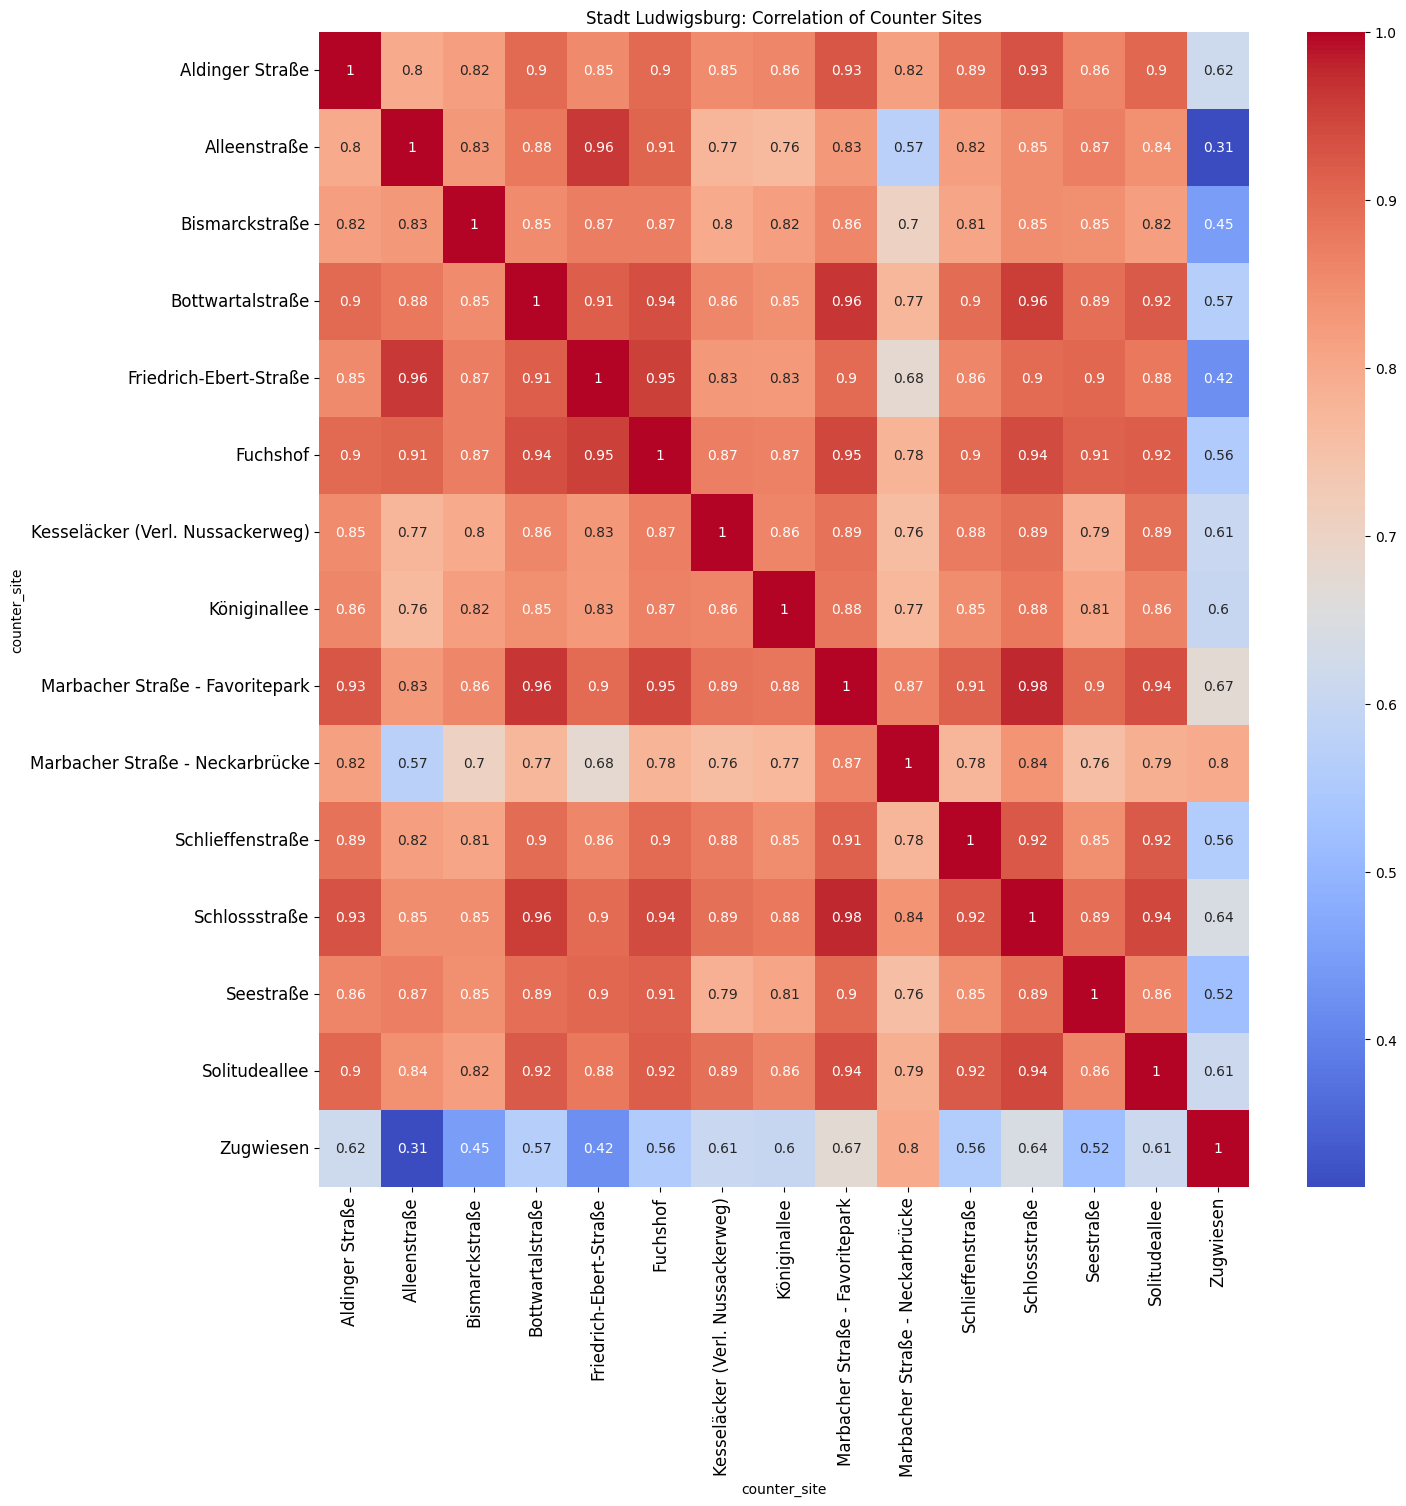

In [261]:
# 3.1 pivot table for correlation matrix
df_domain_pivot = df_domain.pivot_table(
    index = 'iso_timestamp',
    columns = 'counter_site',
    values = 'count',
    aggfunc='sum'
)

# we want to see how many timestamps have data for both sites
mask = df_domain_pivot.notna().astype(int)
overlap = mask.T.dot(mask)
# 3.2 compute correlation matrix and plot heatmap
corr_matrix = df_domain_pivot.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title(f"{title_domain}: Correlation of Counter Sites")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

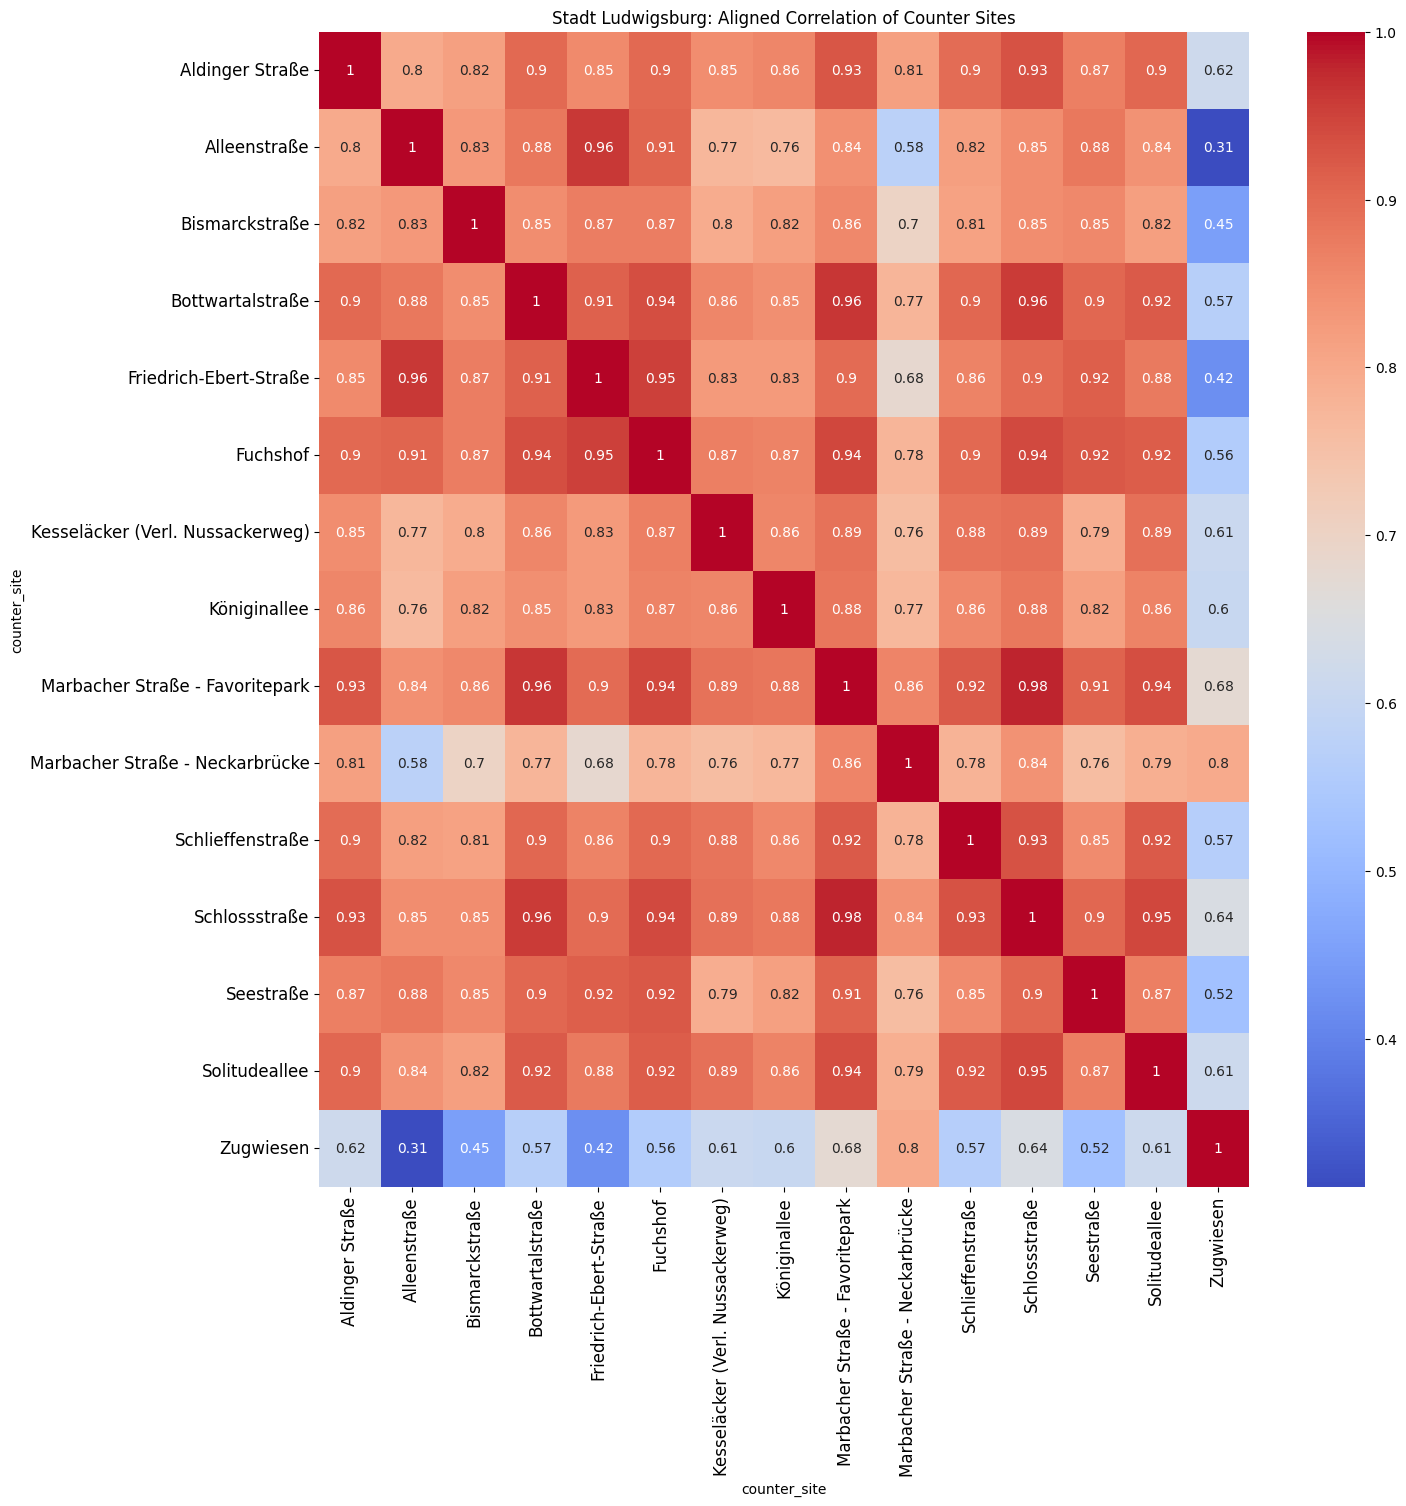

In [262]:
# 3.3 correlation matrix for just times where all sites have data
aligned = df_domain_pivot.dropna()
corr_matrix1 = aligned.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm')
plt.title(f"{title_domain}: Aligned Correlation of Counter Sites")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

0.011517738334702377


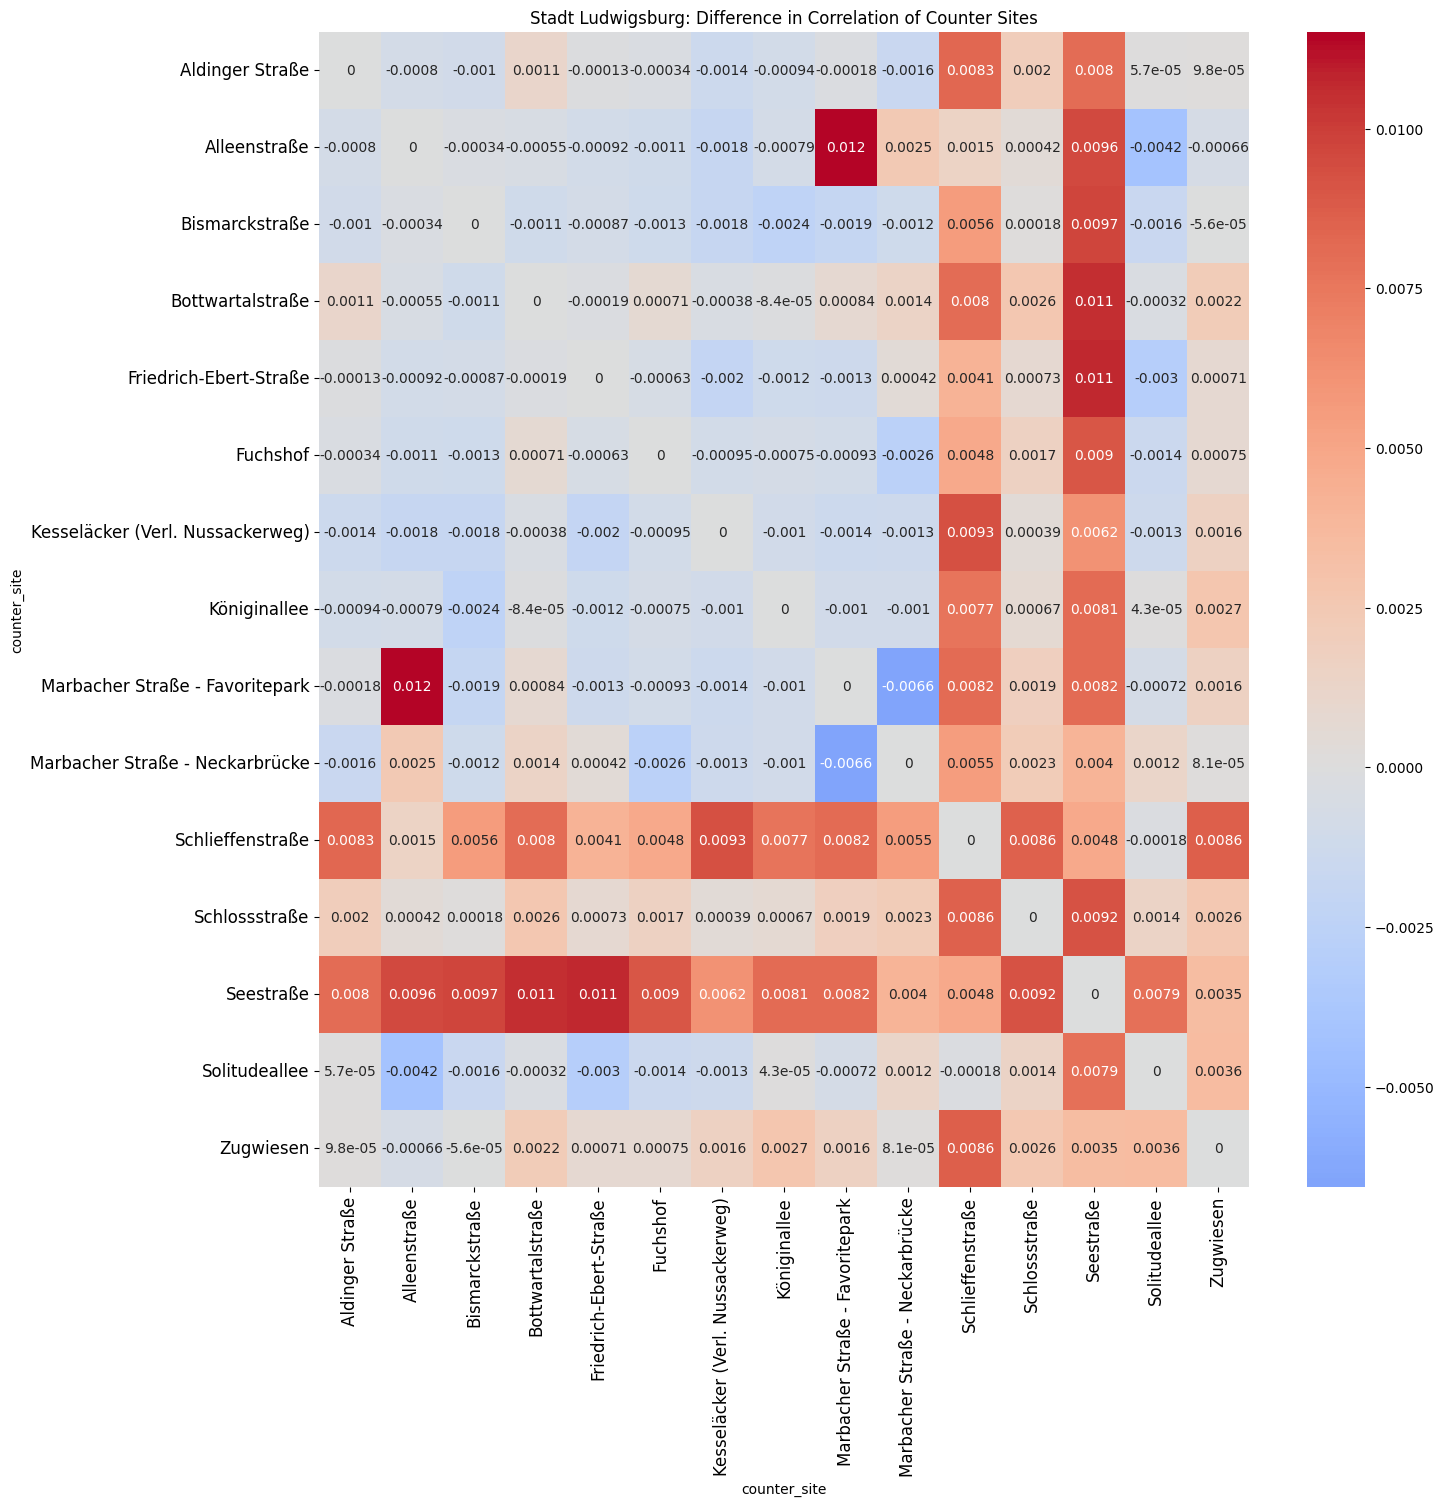

In [263]:
# 3.4 difference between the two correlation matrices
corr_diff = corr_matrix1 - corr_matrix
print(abs(corr_diff).max().max())

plt.figure(figsize=(15, 15))
sns.heatmap(corr_diff, annot=True, cmap='coolwarm', center=0)
plt.title(f"{title_domain}: Difference in Correlation of Counter Sites")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Figure: Difference in Correlations. 

To assess the robustness of correlations across counter sites, we compared the correlation matrix computed using all available time points with the matrix computed only from time points where all sites were simultaneously active.  

The maximum difference observed between corresponding pairwise correlations was 0.12, indicating that the overall correlation structure is largely unaffected by differences in temporal coverage.

#### 4. Visualization

##### 4.1 Distance Measures

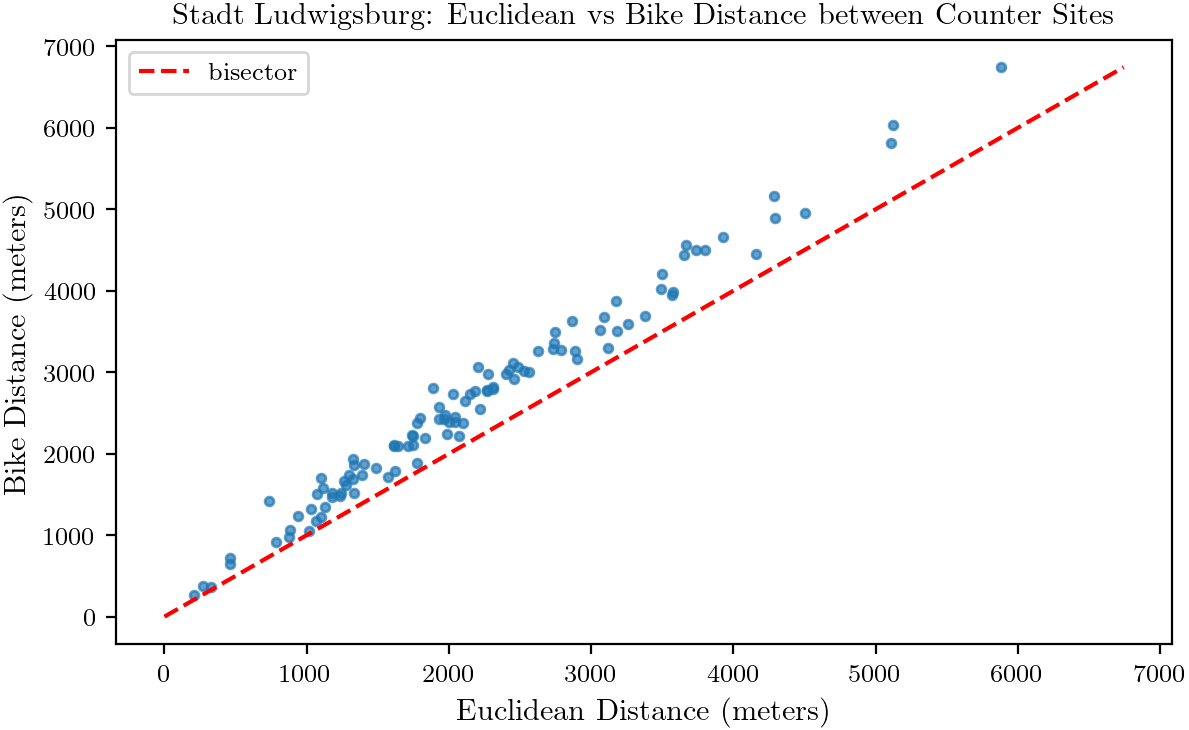

In [264]:
# 4.1.1 check if any bike distances are shorter than euclidean distances (should not be possible)
dist_diff = dist_matrix - dist_matrix_euclid
if (dist_diff < 0).any().any():
    print("Some bike distances are shorter than euclidean distances.")

# 4.1.2 euclidean vs bike distance scatter plot
euclidean_distances = []
bike_distances = []
for site_a in sites1:
    for site_b in sites1:
        if site_a >= site_b:
            continue
        euclidean_distances.append(dist_matrix_euclid.loc[site_a, site_b])
        bike_distances.append(dist_matrix.loc[site_a, site_b])

with plt.rc_context(get_style(rel_width=1,display_dpi=200)):
    plt.scatter(euclidean_distances, bike_distances, s=10)
    ## we need a bisector line for reference (again check for correctness)
    max_dist = max(max(euclidean_distances), max(bike_distances))
    plt.plot([0, max_dist], [0, max_dist], color='red', linestyle='--', label='bisector')
    plt.legend()
    plt.xlabel("Euclidean Distance (meters)")
    plt.ylabel("Bike Distance (meters)")
    plt.title(f"{title_domain}: Euclidean vs Bike Distance between Counter Sites")
    plt.show()

The figure compares Euclidean distances with bike distances. The diagonal line (bisector) serves as a visual check: any point below the red line indicates an error, as bike distances should never be shorter than Euclidean distances.  

We can see that the points lie close to the bisector and show little spread, indicating that Euclidean and bike distances do not differ much. This suggests that the stations are well connected.


##### 4.2 Distance and Correlation

In this step, we examine how correlation varies with distance.  
As expected, the further apart two counter sites are, the lower their count correlation tends to be.  

Ludwigsburg provides a clear example of this trend: sites that are further apart show noticeably weaker correlations.

Stadt: Stadt Ludwigsburg


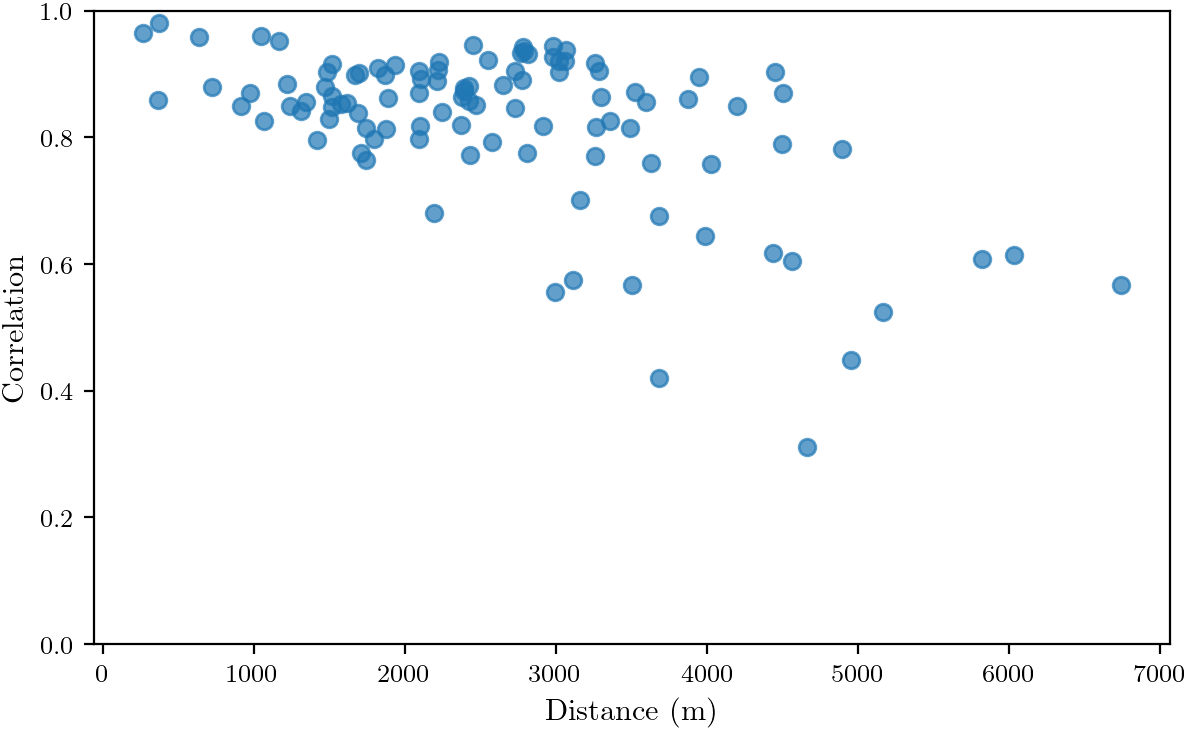

In [265]:
# 4.2.1 bike distance vs correlation plot
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix.loc[site1, site2]
        correlation = corr_matrix1.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)

filename = f"bike_distance_vs_correlation_{title_domain.replace(' ', '_').lower()}.png"
filepath = distcorr_plot_dir / filename

with plt.rc_context(get_style(rel_width=1,display_dpi=200)):
    print("Stadt:",title_domain)
    plt.scatter(distance_values, correlations)
    plt.xlabel("Distance (m)")
    plt.ylabel("Correlation")
    plt.ylim(0, 1)
    #plt.title(f"{title_domain}: Distance vs. Correlation between Counter Sites")
    plt.savefig(filepath, dpi=300, bbox_inches="tight")
    plt.show()


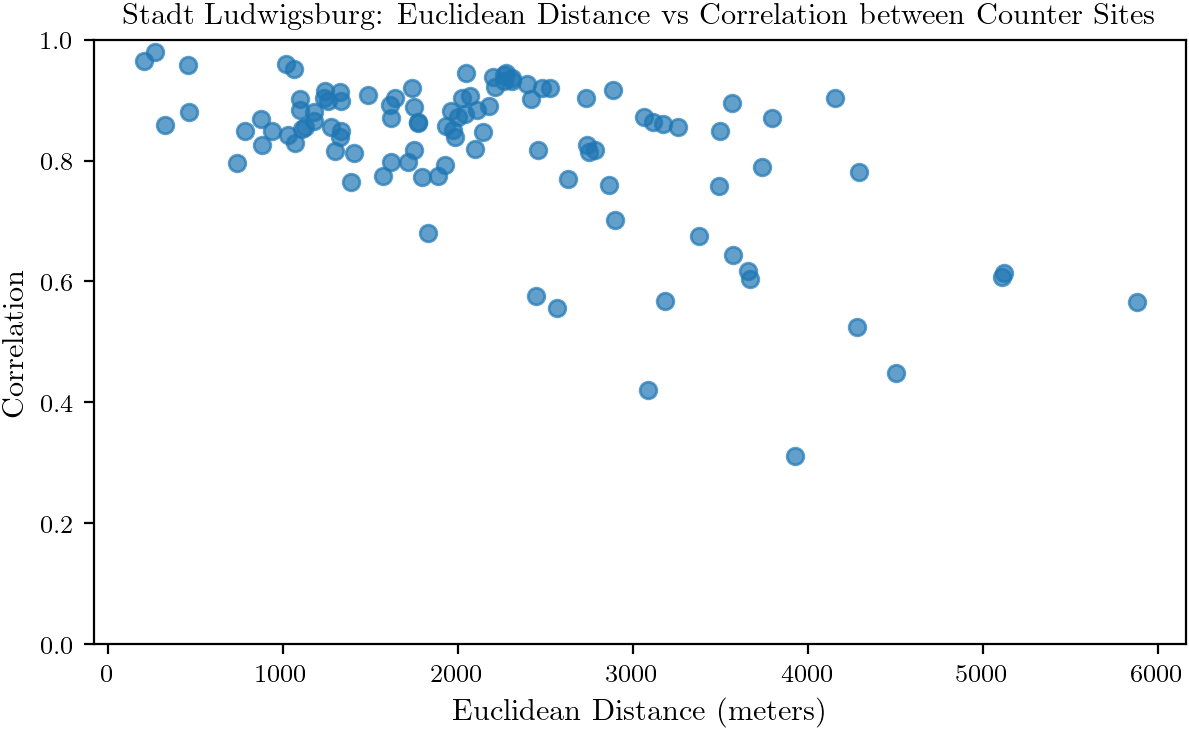

In [266]:
# 4.2.1 euclidean distance vs correlation plot
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix_euclid.loc[site1, site2]
        correlation = corr_matrix1.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)

with plt.rc_context(get_style(rel_width=1,display_dpi=200)):
    plt.scatter(distance_values, correlations)
    plt.xlabel("Euclidean Distance (meters)")
    # set y limit to 0 and 1
    plt.ylim(0, 1)
    plt.ylabel("Correlation")
    plt.title(f"{title_domain}: Euclidean Distance vs Correlation between Counter Sites")
    plt.show()

In [267]:
from tabulate import tabulate

# 5. summary statistics table
def upper_tri_values(df):
    values = []
    sites = df.index
    for i in range(len(sites)):
        for j in range(i + 1, len(sites)):
            values.append(df.iloc[i, j])
    return np.array(values)

euclid_vals = upper_tri_values(dist_matrix_euclid)
bike_vals = upper_tri_values(dist_matrix)
diff_vals = upper_tri_values(diff_matrix)
corr_vals = upper_tri_values(corr_matrix1)

def summarize(values):
    return {
        'Mean': np.mean(values),
        'Median': np.median(values),
        'Std': np.std(values),
        'Min': np.min(values),
        'Max': np.max(values)
    }

summary_table = pd.DataFrame({
    'Euclid Distance (m)': summarize(euclid_vals),
    'Bike Distance (m)': summarize(bike_vals),
    'Difference (m)': summarize(diff_vals),
    'Correlation': summarize(corr_vals)
})

filename = TABLES_DIR / f"summary_statistics_{title_domain.replace(' ', '_').lower()}.md"
filepath = TABLES_DIR / filename
summary_table.to_markdown(filename)

summary_table

,Euclid Distance (m),Bike Distance (m),Difference (m),Correlation
Mean,2184.844487,2637.788574,452.944088,0.822736
Median,2025.898003,2453.067300,458.452029,0.857614
Std,1110.705505,1247.813988,213.169111,0.124208
Min,205.961083,267.293556,32.674393,0.311696
Max,5880.954814,6744.260413,918.882975,0.979811
